# Derin Öğrenme (FET312) Final Projesi: ResNet-18 ile Trafik İşareti Tanıma

Ramazan Bozkurt - 22040301027

Bu çalışma, Alman Trafik İşareti Tanıma Karşılaştırması (GTSRB) veri seti üzerinde derin öğrenme teknikleri kullanılarak gerçekleştirilmiştir. Proje kapsamında, vize döneminde geliştirilen temel modellere ek olarak, daha derin ve gelişmiş bir mimari olan ResNet-18 kullanılmıştır. Modelin eğitiminde transfer learning tekniklerinden faydalanılmış ve PyTorch kütüphanesi temel alınmıştır.

## 1. Kütüphanelerin Yüklenmesi
Proje boyunca veri işleme, model oluşturma ve performans ölçümü için gerekli olan kütüphaneleri sisteme dahil ediyoruz.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_fscore_support
from tqdm import tqdm

## 2. Yapılandırma ve Parametreler
Modelin eğitim sürecinde kullanılacak olan hiperparametreleri ve dosya yollarını bu bölümde tanımlıyoruz.

In [2]:
TRAIN_DATA_DIR = 'GTSRB/Final_Training/Images'
TEST_DATA_DIR = 'GTSRB_Final_Test/Final_Test/Images'
TEST_CSV_PATH = 'GT-final_test.csv'

BATCH_SIZE = 64
NUM_CLASSES = 43
LEARNING_RATE = 3e-4
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "resnet18_gtsrb_clean.pth"

## 3. Veri Seti Analizi ve Görselleştirme
Hocamızın yönergesinde belirttiği üzere, veri setindeki sınıf dağılımını analiz etmek modelin yanlılık (bias) durumunu anlamak için kritiktir. Aşağıdaki grafiklerde sınıfların örnek sayılarını ve yüzdelik dağılımlarını görebiliriz.

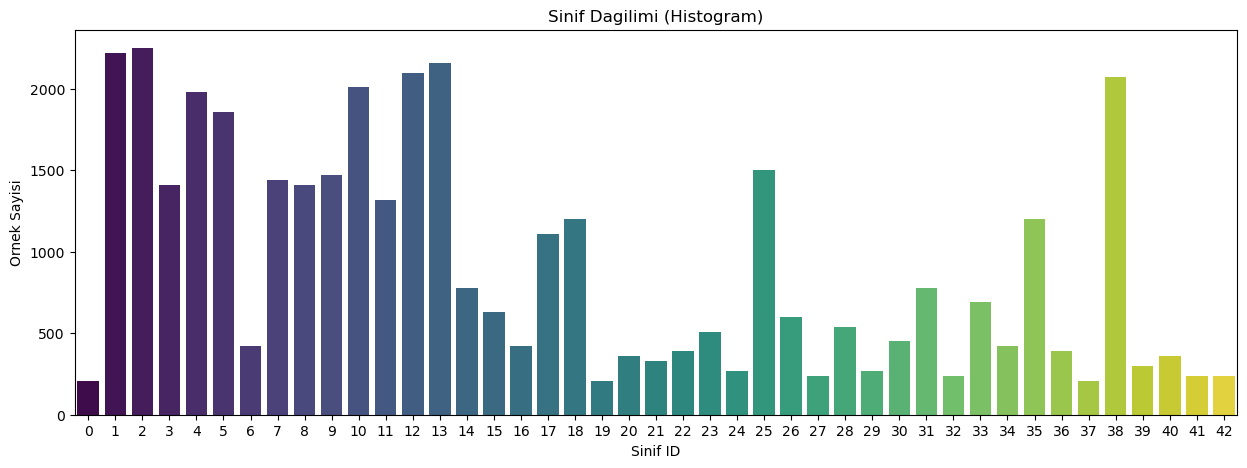

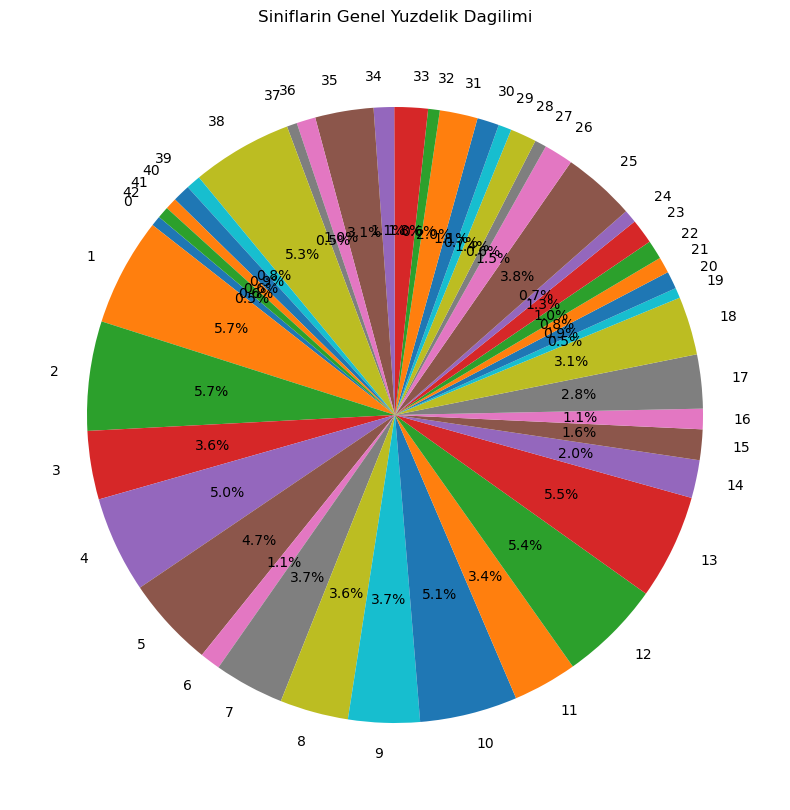

In [4]:
full_dataset_raw = datasets.ImageFolder(TRAIN_DATA_DIR)
labels = [label for _, label in full_dataset_raw.imgs]
label_counts = pd.Series(labels).value_counts().sort_index()

plt.figure(figsize=(15, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="viridis", legend=False)
plt.title("Sinif Dagilimi (Histogram)")
plt.xlabel("Sinif ID")
plt.ylabel("Ornek Sayisi")
plt.show()

plt.figure(figsize=(10, 10))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Siniflarin Genel Yuzdelik Dagilimi")
plt.show()

## 4. Veri Ön İşleme ve Data Augmentation
Görüntü işleme projelerinde modelin genelleme yeteneğini artırmak amacıyla veri çoklama (data augmentation) teknikleri uygulanmıştır. Bu kapsamda rastgele döndürme, kırpma ve renk titremesi (color jitter) gibi yöntemler kullanılmıştır.

In [5]:
train_tf = transforms.Compose([
    transforms.Resize((72, 72)),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.3337, 0.3064, 0.3171], [0.2672, 0.2564, 0.2629])
])

test_tf = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.3337, 0.3064, 0.3171], [0.2672, 0.2564, 0.2629])
])

groups = []
for path, label in full_dataset_raw.imgs:
    track_id = os.path.basename(path).split('_')[0]
    groups.append(f"{label}_{track_id}")

gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(np.zeros(len(groups)), full_dataset_raw.targets, groups))

train_ds = Subset(full_dataset_raw, train_idx)
val_ds = Subset(full_dataset_raw, val_idx)

train_ds.dataset.transform = train_tf
val_ds.dataset.transform = test_tf

train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, BATCH_SIZE, shuffle=False)

## 5. Model Mimarisi ve Eğitim
Final raporu için seçilen ResNet-18 mimarisi, ImageNet ağırlıkları ile başlatılmıştır. Son katman (FC) projemizdeki 43 sınıfa uygun şekilde değiştirilmiştir.

In [6]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

def evaluate(loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    return y_true, y_pred, np.array(y_probs)

best_acc = 0.0
for epoch in range(EPOCHS):
    model.train()
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
    
    y_t, y_p, _ = evaluate(val_loader)
    val_acc = accuracy_score(y_t, y_p)
    print(f"Validation Accuracy: {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)

Epoch 1/15: 100%|██████████| 490/490 [09:46<00:00,  1.20s/it]


Validation Accuracy: 0.9695


Epoch 2/15: 100%|██████████| 490/490 [04:38<00:00,  1.76it/s]


Validation Accuracy: 0.9790


Epoch 3/15: 100%|██████████| 490/490 [04:38<00:00,  1.76it/s]


Validation Accuracy: 0.9805


Epoch 4/15: 100%|██████████| 490/490 [04:37<00:00,  1.76it/s]


Validation Accuracy: 0.9849


Epoch 5/15: 100%|██████████| 490/490 [04:38<00:00,  1.76it/s]


Validation Accuracy: 0.9860


Epoch 6/15: 100%|██████████| 490/490 [04:38<00:00,  1.76it/s]


Validation Accuracy: 0.9855


Epoch 7/15: 100%|██████████| 490/490 [04:38<00:00,  1.76it/s]


Validation Accuracy: 0.9738


Epoch 8/15: 100%|██████████| 490/490 [04:37<00:00,  1.76it/s]


Validation Accuracy: 0.9887


Epoch 9/15: 100%|██████████| 490/490 [04:40<00:00,  1.75it/s]


Validation Accuracy: 0.9911


Epoch 10/15: 100%|██████████| 490/490 [04:38<00:00,  1.76it/s]


Validation Accuracy: 0.9809


Epoch 11/15: 100%|██████████| 490/490 [04:38<00:00,  1.76it/s]


Validation Accuracy: 0.9823


Epoch 12/15: 100%|██████████| 490/490 [04:38<00:00,  1.76it/s]


Validation Accuracy: 0.9830


Epoch 13/15: 100%|██████████| 490/490 [04:39<00:00,  1.76it/s]


Validation Accuracy: 0.9922


Epoch 14/15: 100%|██████████| 490/490 [04:38<00:00,  1.76it/s]


Validation Accuracy: 0.9838


Epoch 15/15: 100%|██████████| 490/490 [04:38<00:00,  1.76it/s]


Validation Accuracy: 0.9691


## 6. Performans Değerlendirmesi ve ROC Analizi
Eğitim tamamlandıktan sonra en iyi ağırlıkları yüklüyor ve test seti üzerinde kapsamlı bir değerlendirme yapıyoruz. Bu aşamada Accuracy, Precision, Recall ve F1-Score metriklerinin yanı sıra hocamızın talep ettiği ROC eğrisini de çizdiriyoruz.

Sinif Bazli Performans Raporu:

              precision    recall  f1-score   support

           0      1.000     0.983     0.992        60
           1      0.969     0.990     0.979       720
           2      0.995     0.995     0.995       750
           3      0.993     0.976     0.984       450
           4      0.994     0.980     0.987       660
           5      0.962     0.995     0.978       630
           6      1.000     0.740     0.851       150
           7      0.964     0.998     0.980       450
           8      0.996     0.993     0.994       450
           9      0.992     0.998     0.995       480
          10      1.000     0.995     0.998       660
          11      0.983     0.979     0.981       420
          12      0.991     0.983     0.987       690
          13      0.994     0.994     0.994       720
          14      1.000     1.000     1.000       270
          15      1.000     0.995     0.998       210
          16      0.993     1.000     0.997      

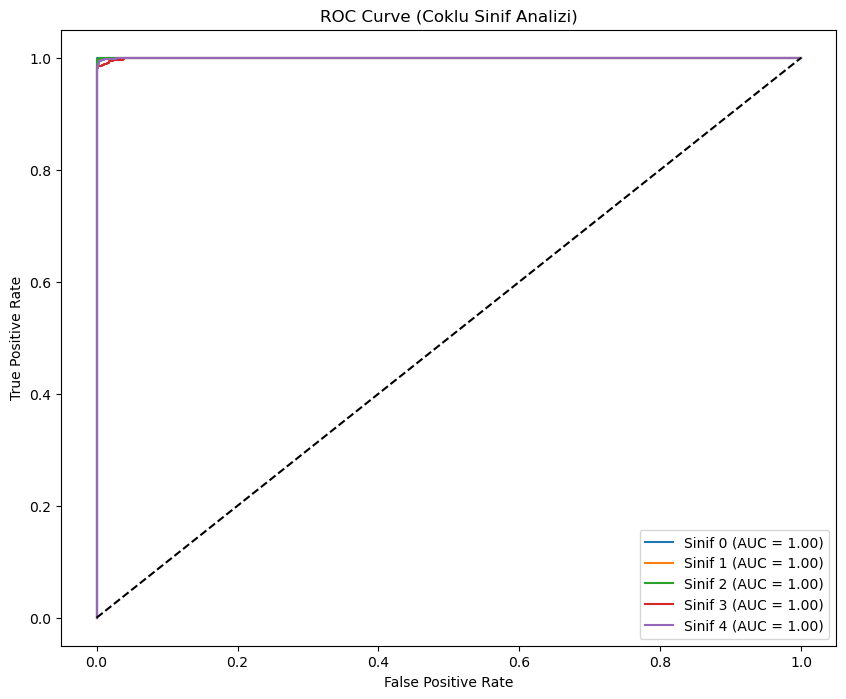

In [8]:
class GTSRBTestDataset(Dataset):
    def __init__(self, csv, root, tf):
        self.data = pd.read_csv(csv, sep=';')
        self.root = root
        self.tf = tf
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 7])
        return self.tf(image), label

model.load_state_dict(torch.load(MODEL_PATH))
test_loader = DataLoader(GTSRBTestDataset(TEST_CSV_PATH, TEST_DATA_DIR, test_tf), batch_size=BATCH_SIZE, shuffle=False)

y_true, y_pred, y_probs = evaluate(test_loader)

print("Sinif Bazli Performans Raporu:\n")
print(classification_report(y_true, y_pred, digits=3))

# ROC Curve Cizimi (Ilk 5 sinif icin ornek)
plt.figure(figsize=(10, 8))
for i in range(5):
    fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), y_probs[:, i])
    plt.plot(fpr, tpr, label=f'Sinif {i} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Coklu Sinif Analizi)')
plt.legend()
plt.show()